In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

Load the MNIST dataset

In [2]:
from utils.data_loader import load_mnist_data

# Load MNIST
(train_images, train_labels), (test_images, test_labels) = load_mnist_data()
print(f"MNIST shapes: {train_images.shape}, {train_labels.shape}, {test_images.shape}, {test_labels.shape}")

MNIST shapes: (60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,)


Plot a few samples to check all is good

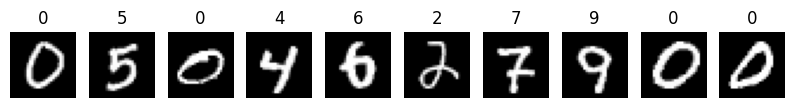

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_samples(images, labels, num_samples=10):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(num_samples, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx].reshape(28,28), cmap='gray')
        plt.title(f"{labels[idx]}")
        plt.axis("off")
    plt.show()

plot_samples(train_images, train_labels)

Train the small proof-of-concept model LesNet

In [4]:
from utils.train_utils import train_model

cnn, cnn_history = train_model(model_name='cnn', epochs=10, train_images=train_images, train_labels=train_labels, test_images=test_images, test_labels=test_labels) # change to LeNet for LeNet model

c:\Users\sonia\anaconda3\envs\fragile_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 298ms/step - accuracy: 0.8069 - loss: 0.5793 - val_accuracy: 0.9847 - val_loss: 0.0467
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 135s 288ms/step - accuracy: 0.9725 - loss: 0.0919 - val_accuracy: 0.9903 - val_loss: 0.0319
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 105s 223ms/step - accuracy: 0.9800 - loss: 0.0670 - val_accuracy: 0.9909 - val_loss: 0.0269
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 210ms/step - accuracy: 0.9841 - loss: 0.0519 - val_accuracy: 0.9930 - val_loss: 0.0218
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 107s 229ms/step - accuracy: 0.9873 - loss: 0.0424 - val_accuracy: 0.9925 - val_loss: 0.0222
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 218ms/step - accuracy: 0.9881 - loss: 0.0399 - val_accuracy: 0.9934 - val_loss: 0.0214
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 128s 188ms/step - accuracy: 0.9890 - loss: 0.0360 - val_accuracy: 0.9927 - val_loss: 0.0223
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - accuracy: 0.9895 - l

Select a subset of 100 training points for this study

In [5]:
np.random.seed(7)
subset_size = 100
all_indices = np.arange(len(train_images))
subset_indices = np.random.choice(all_indices, subset_size, replace=False)
train_images_subset = train_images[subset_indices]
train_labels_subset = train_labels[subset_indices]

In [36]:
from utils.ground_truth_influence import compute_ground_truth_influences

# Select a test sample 
test_index = 6
test_sample = test_images[test_index]
test_label = test_labels[test_index]

ground_truth_influences = compute_ground_truth_influences(
    cnn, train_images_subset, train_labels_subset, test_sample, test_label,
    sample_indices=list(range(subset_size)), fine_tune_epochs=30, batch_size=1
)

print(ground_truth_influences)

[-1.18812022e-03  6.51262224e-01  3.88224050e-03  1.25145301e-01
 -1.05318986e-03 -1.90637889e-04 -1.12065277e-03  9.28430855e-02
 -1.22841215e-03 -1.22829294e-03  1.57125533e+00 -5.02810115e-04
 -1.20588182e-03 -1.05342828e-03  3.86848301e-03  5.35019159e+00
 -1.18096801e-03  2.43501568e+00  6.48899600e-02 -1.12935412e-03
  3.58952314e-01 -1.19980238e-03 -4.84465330e-04  1.08863413e-02
  9.26690251e-02 -1.20766996e-03 -4.27884632e-04  1.02364406e-01
  2.81758048e-03  4.36203748e-01  1.22981215e+01 -1.11385854e-03
  1.04991460e+00  7.94996858e-01  1.87720396e-02 -1.17596146e-03
  4.93466043e+00  2.00029165e-01  7.63379112e-02 -1.22841215e-03
  2.21017189e+01 -1.15426676e-03  4.75642115e-01  2.59913579e-02
 -1.21696817e-03  7.08055139e-01  5.25020933e+00  2.36877561e-01
  1.10607804e-03  1.13648236e+00  2.23422833e-02  1.22928675e-02
 -1.22805452e-03 -1.21982908e-03  4.10906839e+00  5.43601857e-03
 -1.22841215e-03  2.49571845e-01  9.86689031e-01  8.26987438e-03
  8.23385827e-03  3.14198

In [37]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import tensorflow as tf

from utils.influence_functions import compute_influence_and_meta_on_dataset

# Define loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Compute standard influence estimates on a subset of training data (first 10 samples)
std_influences, meta_influences = compute_influence_and_meta_on_dataset(
    cnn, train_images_subset, train_labels_subset, test_sample, test_label, loss_fn,
    damping=0.1, sample_indices=list(range(subset_size)), epsilon=1e-3
)

std_influences = -std_influences

scaling_factor = np.median(np.abs(ground_truth_influences)) / np.median(np.abs(std_influences))
std_influences = std_influences * scaling_factor

print(std_influences)

[ 1.35571332e-08  7.21162045e-03  1.89183448e-02  1.61568085e+02
 -2.99608130e-02  1.00001954e-02  1.14109488e-02  2.89139035e-03
  3.56550537e+03 -8.81588785e-04  3.11429118e-04 -1.40479164e+01
 -1.12459202e-06 -1.30889378e-02 -5.30511781e-04 -3.52511473e-04
  2.49846399e-01 -1.00365913e+00  4.28473300e-07  1.80346756e+01
  1.40478224e-01  9.26694202e+00  6.21029030e-05 -1.85099039e-02
  2.95503088e-03  1.03770685e-03  5.20583271e-05  3.99952364e+00
  3.54534450e-06  1.24729195e+01  8.89427414e+01 -1.02031548e-02
  5.04371785e-02  6.10842891e-02  1.84063116e-04  5.12314224e+00
  3.76305252e-04  3.42119529e-06  1.15727580e+00  4.12093641e-07
  2.19549090e-08 -6.69036712e-03 -1.52570801e-05  4.66026306e+00
  7.41680537e-07 -1.71275333e-01 -1.42996639e-01  1.81458654e-05
  1.83196942e-04 -1.71518400e-02 -6.24469307e-04  1.59845233e-03
 -1.26157561e-03 -2.44339790e-05 -1.43739525e-02  4.47821058e-02
 -1.67283192e-02  3.74659607e+02 -1.24581354e-02  2.35212827e+00
  3.33486535e-02  1.45978

In [38]:
meta_influences = -meta_influences*scaling_factor
print(meta_influences)

[-8.8956284e-08 -9.6447624e-02 -2.7431810e+00 -5.8142095e+03
  2.1901441e+00 -1.1629012e-01  1.3680935e-01 -3.0379467e-02
 -1.2416722e+04  3.2978989e-02  2.1822309e-02  5.3632849e+02
  1.0478075e-05 -1.1085718e+00  3.7570433e-03  1.0252844e-03
 -7.7044945e+00  1.0039537e+01 -2.9514852e-04 -1.5907234e+02
  5.9611363e+00 -1.3748851e+01  2.2318419e-03  1.3744034e-01
 -2.9445425e-02 -1.7507881e-02 -1.0410610e-03 -2.1553019e+01
 -5.8637156e-06  6.0934746e+01 -4.1200615e+03  4.7959697e-01
  4.5919093e-01  4.4841114e-01  6.5400670e-03 -9.6971527e+01
  2.8572192e-03 -3.5491161e-04  2.8973494e+01  2.3902599e-04
 -4.8344106e-07 -5.2272630e-01 -9.7049103e-04 -2.5436401e+01
 -4.3285031e-06  8.8409452e+00  1.2800920e+00 -2.0762454e-03
  1.7129402e-01 -5.2800906e-01  1.0107790e-02  1.0005214e-01
 -3.6768444e-02 -3.2015520e-04  9.4009972e-01 -3.4112324e+03
  3.7016669e-01 -3.9842648e+02 -5.7277322e-01  3.5968433e+02
  1.5256710e+00 -1.1830672e-05  3.0729298e+01  1.2049181e+03
  3.4829764e+02  1.42546

In [39]:
print("Unique values in ground_truth_influences:", np.unique(ground_truth_influences))
print("Variance in ground_truth_influences:", np.var(ground_truth_influences))

Unique values in ground_truth_influences: [-1.22841215e-03 -1.22829294e-03 -1.22817373e-03 -1.22805452e-03
 -1.22161722e-03 -1.21982908e-03 -1.21887540e-03 -1.21708738e-03
 -1.21696817e-03 -1.20766996e-03 -1.20588182e-03 -1.20361696e-03
 -1.19980238e-03 -1.19515334e-03 -1.18812022e-03 -1.18680892e-03
 -1.18096801e-03 -1.17596146e-03 -1.16785569e-03 -1.15426676e-03
 -1.14186993e-03 -1.14020112e-03 -1.12935412e-03 -1.12065277e-03
 -1.11385854e-03 -1.05342828e-03 -1.05318986e-03 -9.85969789e-04
 -9.54268384e-04 -5.02810115e-04 -4.84465330e-04 -4.27884632e-04
 -1.90637889e-04  3.12253367e-04  1.10607804e-03  2.81758048e-03
  3.02070333e-03  3.86848301e-03  3.88224050e-03  5.43601857e-03
  7.54423114e-03  8.23385827e-03  8.26987438e-03  8.38830322e-03
  9.00195353e-03  1.08863413e-02  1.22928675e-02  1.55032352e-02
  1.82245709e-02  1.87720396e-02  2.23422833e-02  2.59913579e-02
  3.89264748e-02  4.42251004e-02  4.70727161e-02  6.14398085e-02
  6.34640381e-02  6.48899600e-02  6.80350885e-02

In [40]:
pearson_corr, _ = pearsonr(std_influences, ground_truth_influences)
spearman_corr, _ = spearmanr(std_influences, ground_truth_influences)
print("Pearson correlation:", pearson_corr)
print("Spearman correlation:", spearman_corr)

Pearson correlation: -0.027186263
Spearman correlation: 0.053516562746384645


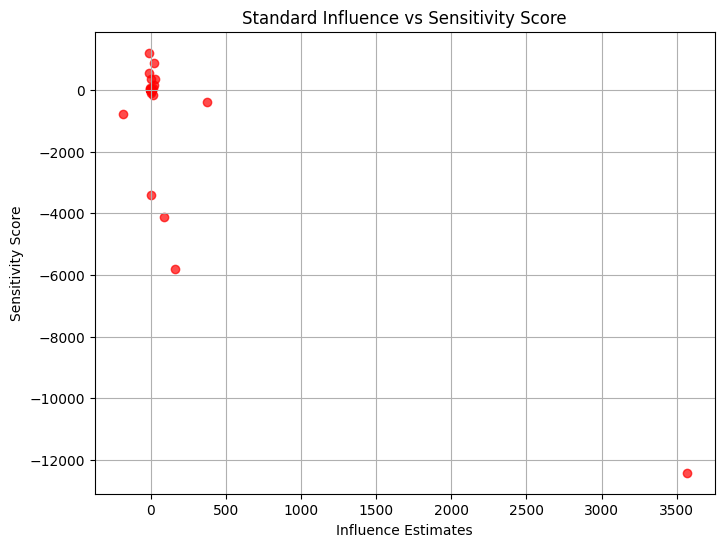

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(std_influences, meta_influences, color='red', alpha=0.7)
plt.xlabel("Influence Estimates")
plt.ylabel("Sensitivity Score")
plt.title("Standard Influence vs Sensitivity Score")
plt.grid(True)
plt.show()

In [42]:
top_k = 10
top_indices = np.argsort(np.abs(std_influences))[-top_k:][::-1]  # Sort by magnitude (descending)

def plot_top_influential(images, labels, scores, meta_scores, indices, title, variant="normal"):
    plt.figure(figsize=(top_k, 2.5))
    for i, idx in enumerate(indices):
        plt.subplot(1, top_k, i + 1)
        plt.imshow(images[idx].reshape(28, 28), cmap='gray')
        if(variant == "adjusted"):
            plt.title(f"Inf:{scores[idx]:.2f}\nPrev={meta_scores[idx]:.2f}", fontsize=8)
        else:
            plt.title(f"Inf:{scores[idx]:.2f}\nμ={meta_scores[idx]:.2f}", fontsize=8)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

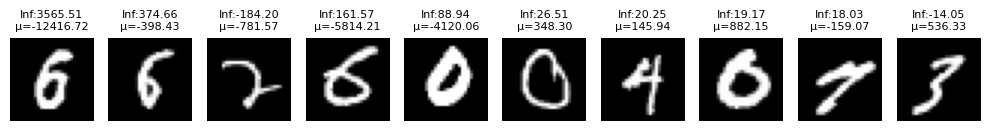

In [43]:
plot_top_influential(train_images_subset, train_labels_subset, std_influences, meta_influences, top_indices, "")

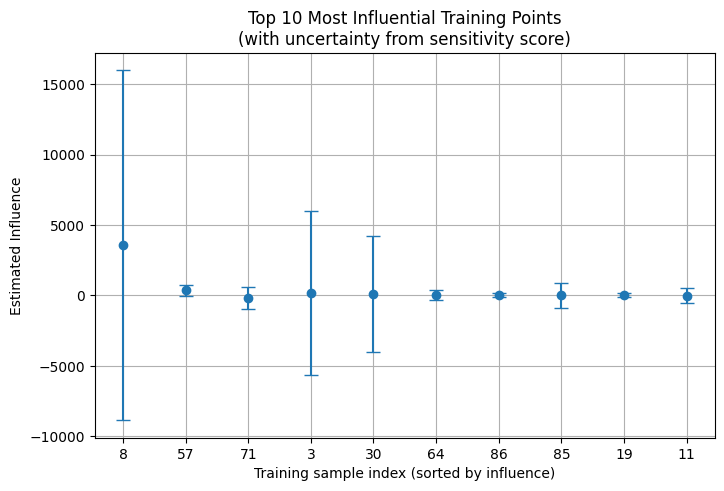

In [44]:
import numpy as np
import matplotlib.pyplot as plt

top10_std = std_influences[top_indices]
top10_meta = meta_influences[top_indices]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(10), top10_std, yerr=np.abs(top10_meta), fmt='o', capsize=5)
plt.xticks(np.arange(10), top_indices)
plt.xlabel("Training sample index (sorted by influence)")
plt.ylabel("Estimated Influence")
plt.title("Top 10 Most Influential Training Points\n(with uncertainty from sensitivity score)")
plt.grid(True)
plt.show()


Best Pearson threshold: 0.579 (r = -0.031)
Best Spearman threshold: 0.051 (ρ = 0.164)
Best Trade-off threshold: 0.091 (r = -0.041, ρ = 0.150)


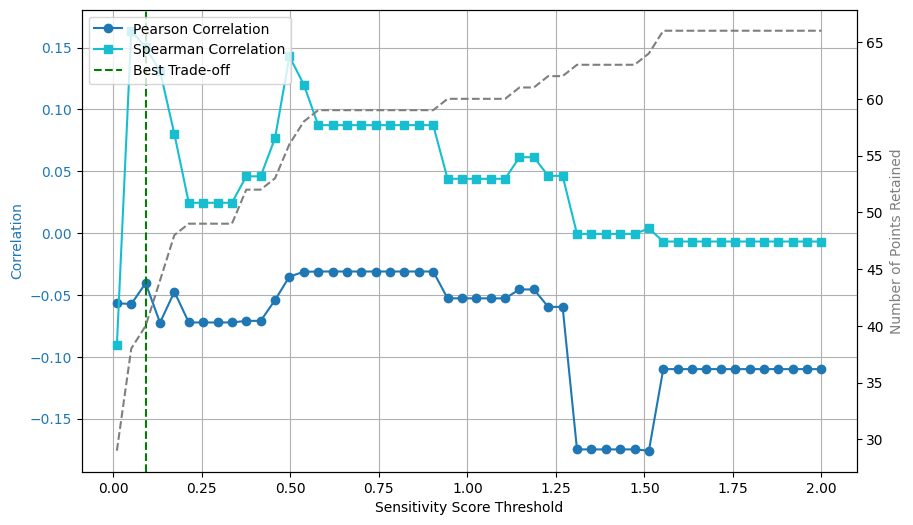

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

thresholds = np.linspace(0.01, 2.0, 50)
pearson_corrs = []
spearman_corrs = []
num_points_retained = []

for t in thresholds:
    mask = np.abs(meta_influences) < t
    retained = np.sum(mask)
    num_points_retained.append(retained)

    if retained < 2:
        pearson_corrs.append(np.nan)
        spearman_corrs.append(np.nan)
    else:
        std_filtered = std_influences[mask]
        gt_filtered = ground_truth_influences[mask]
        p_corr, _ = pearsonr(std_filtered, gt_filtered)
        s_corr, _ = spearmanr(std_filtered, gt_filtered)
        pearson_corrs.append(p_corr)
        spearman_corrs.append(s_corr)

# Find best
pearson_corrs = np.array(pearson_corrs)
spearman_corrs = np.array(spearman_corrs)

best_pearson_idx = np.nanargmax(pearson_corrs)
best_spearman_idx = np.nanargmax(spearman_corrs)

# Trade-off: Spearman + Pearson
combined = pearson_corrs + spearman_corrs
best_tradeoff_idx = np.nanargmax(combined)

print(f"Best Pearson threshold: {thresholds[best_pearson_idx]:.3f} (r = {pearson_corrs[best_pearson_idx]:.3f})")
print(f"Best Spearman threshold: {thresholds[best_spearman_idx]:.3f} (ρ = {spearman_corrs[best_spearman_idx]:.3f})")
print(f"Best Trade-off threshold: {thresholds[best_tradeoff_idx]:.3f} (r = {pearson_corrs[best_tradeoff_idx]:.3f}, ρ = {spearman_corrs[best_tradeoff_idx]:.3f})")

fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel("Sensitivity Score Threshold")
ax1.set_ylabel("Correlation", color=color1)
ax1.plot(thresholds, pearson_corrs, label="Pearson Correlation", marker="o", color=color1)
ax1.plot(thresholds, spearman_corrs, label="Spearman Correlation", marker="s", color="tab:cyan")
ax1.axvline(thresholds[best_tradeoff_idx], linestyle='--', color='green', label='Best Trade-off')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc="upper left")
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'tab:gray'
ax2.set_ylabel("Number of Points Retained", color=color2)
ax2.plot(thresholds, num_points_retained, label="# Points Retained", linestyle="--", color=color2)


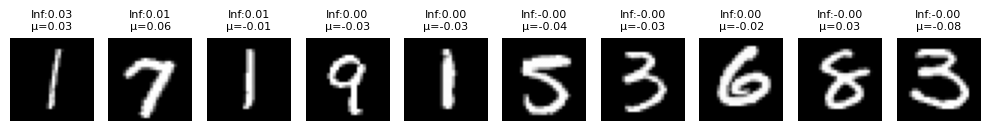

In [46]:
best_mask = np.abs(meta_influences) < thresholds[best_tradeoff_idx]

filtered_std = std_influences[best_mask]
filtered_meta = meta_influences[best_mask]
filtered_images = train_images_subset[best_mask]
filtered_labels = train_labels_subset[best_mask]

top_indices = np.argsort(np.abs(filtered_std))[-top_k:][::-1]

plot_top_influential(filtered_images, filtered_labels, filtered_std, filtered_meta, top_indices, title="")


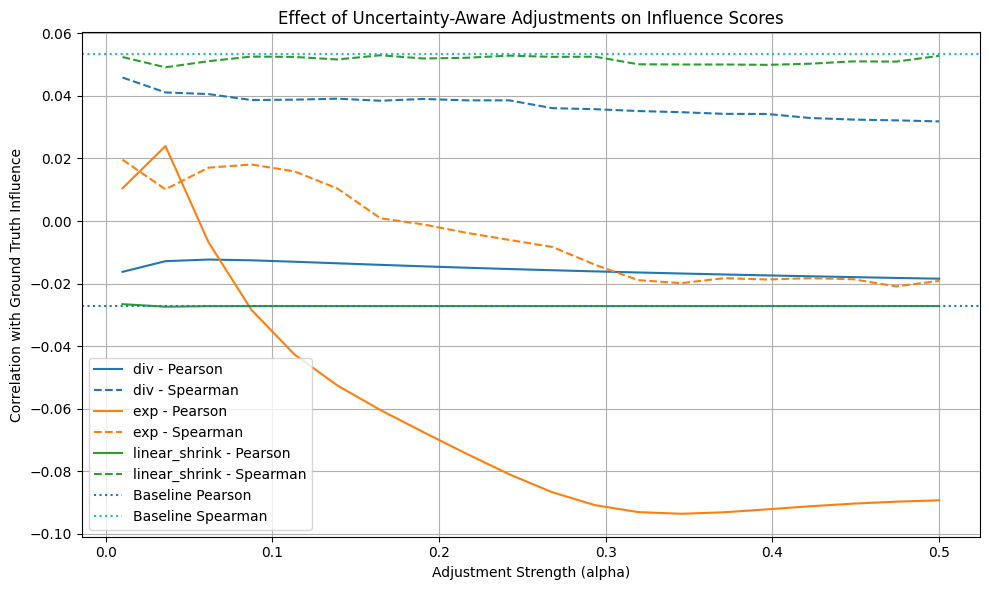

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

adjustment_strengths = np.linspace(0.01, 0.5, 20)
strategies = ['div', 'exp', 'linear_shrink']

results = {s: {'pearson': [], 'spearman': []} for s in strategies}

for alpha in adjustment_strengths:
    # Strategies
    adj1 = std_influences / (1 + alpha * np.abs(meta_influences))  
    adj2 = std_influences * np.exp(-alpha * np.abs(meta_influences))  
    adj3 = std_influences * np.clip((1 - alpha * np.abs(meta_influences)), 0.2, 1.0)  # linear_shrink

    for name, adj in zip(strategies, [adj1, adj2, adj3]):
        p_corr, _ = pearsonr(adj, ground_truth_influences)
        s_corr, _ = spearmanr(adj, ground_truth_influences)
        results[name]['pearson'].append(p_corr)
        results[name]['spearman'].append(s_corr)

# Baseline
pearson_base, _ = pearsonr(std_influences, ground_truth_influences)
spearman_base, _ = spearmanr(std_influences, ground_truth_influences)

strategy_colors = {
    'div': 'tab:blue',
    'exp': 'tab:orange',
    'linear_shrink': 'tab:green'
}

# Plotting
plt.figure(figsize=(10, 6))
for name in strategies:
    color = strategy_colors[name]
    # Plot Pearson with solid line
    plt.plot(adjustment_strengths, results[name]['pearson'], 
             color=color, linestyle='-', label=f'{name} - Pearson')
    # Plot Spearman with dashed line using the same color
    plt.plot(adjustment_strengths, results[name]['spearman'], 
             color=color, linestyle='--', label=f'{name} - Spearman')

# Baseline lines (unchanged from original)
plt.axhline(pearson_base, linestyle=':', color='tab:blue', label='Baseline Pearson')
plt.axhline(spearman_base, linestyle=':', color='tab:cyan', label='Baseline Spearman')

plt.xlabel("Adjustment Strength (alpha)")
plt.ylabel("Correlation with Ground Truth Influence")
plt.title("Effect of Uncertainty-Aware Adjustments on Influence Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best alpha: 0.035789473684210524
Associated Pearson score: 0.023958966987570246
Associated Spearman score: 0.010129620757557443


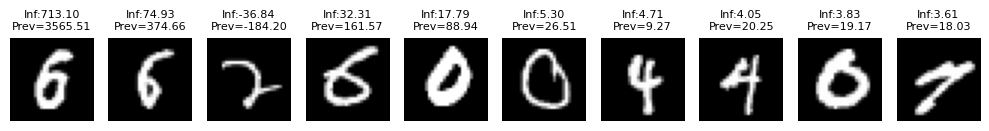

In [53]:
strategy = "exp"
avg_corrs = np.array(results[strategy]['pearson']) + np.array(results[strategy]['spearman'])
best_idx = np.argmax(avg_corrs)
best_alpha = adjustment_strengths[best_idx]

best_pearson = results[strategy]['pearson'][best_idx]
best_spearman = results[strategy]['spearman'][best_idx]

print("Best alpha:", best_alpha)
print("Associated Pearson score:", best_pearson)
print("Associated Spearman score:", best_spearman)

adjusted_scores = std_influences * np.clip((1 - best_alpha * np.abs(meta_influences)), 0.2, 1.0)

top_indices = np.argsort(-np.abs(adjusted_scores))[:top_k]
plot_top_influential(train_images_subset, train_labels_subset, adjusted_scores, std_influences, top_indices, title="", variant="adjusted")
